# **Deep Learning - Final Project**



---




### **Team name: Pain & Panic**

team members: 
T63K63 - Tugyi Beatrix,

IT9P0Z - Heizer Levente

# Imports

In [39]:
!python --version

Python 3.9.7


In [1]:
import torch
!pip install torch_geometric

from torch import nn
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling

!pip install nodevectors

import re
import networkx as nx

import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
import time
import warnings
warnings.simplefilter("ignore", category=UserWarning)
!pip install gensim==3.6
import gensim
warnings.simplefilter("default", category=UserWarning)

import csrgraph as cg
from nodevectors.embedders import BaseNodeEmbedder
! pip install  torch_scatter
from sklearn.metrics import classification_report
from nodevectors import Node2Vec
from torch_geometric.transforms import RandomLinkSplit
import requests
import torch_scatter
from torch_geometric.nn import GINConv
from torch_geometric.nn import  MLP
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics

# Set the device to Cuda if GPU is available

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Utilities

In [5]:
# function to get the first part of the file names of each given file
# in the Facebook graph these are the indexes of the ego-s (the individuals ) )
def get_ego_indexes(files):
  pattern = re.compile(r'\d+')
  ego_indexes = [int(pattern.search(s).group()) for s in files if pattern.search(s)]
  ego_indexes = sorted(set(ego_indexes))
  return ego_indexes

In [6]:
# Class to store all the information about the given graphs
class GraphData:
  edge_index = []
  edge_list = []
  nodes = []
  X = []
  circles = []
  X_names = []
  embeddings = []

  def __init__(self, edges, edge_list, X, circles, X_names, embeddings, nodes):
    self.edge_index = edges
    self.edge_list = edge_list
    self.X = X
    self.circles = circles
    self.X_names = X_names
    self.embeddings = embeddings
    self.nodes = nodes

In [108]:
#This function is to visualize the given graph
def visualize(g, title="Graph", edge='blue'):
    pos = nx.kamada_kawai_layout(g)
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.axis('on')
    nx.draw_networkx(g, pos=pos, node_size=10, edge_color=edge,
                     arrows=False, width=1, style='solid', with_labels= False)
    plt.show()

In [8]:
#This function is for split a graph data's edges into test, validation and train set
def split_data(graph, embeddings_type = 0):
  split = RandomLinkSplit(
      num_val=0.05,  # size of the validation set
      num_test=0.1,  # size of the test set
      is_undirected=True,
      add_negative_train_samples=False, # We do not want negativ edges in the traing set
      neg_sampling_ratio=1.0,   # In the test and validation set the num of negativ edges will be the same as the positives
  )
  # embedding_type is 0, when we want to use the embeddings of the nodes, given by the Node2Vec algorithm
  # if its 1, we use the original representations of the nodes (X) and when it's two we use both of them
  if embeddings_type == 0:
     data = Data(x=graph.embeddings, edge_index=graph.edge_index)
  elif embeddings_type == 1:
     data = Data(x=graph.X, edge_index=graph.edge_index) 
  else:
     data = Data(x=torch.cat((graph.X, graph.embeddings), dim=1), edge_index=graph.edge_index)
     
        
  train_data, val_data, test_data = split(data)

  print('train_data:', train_data)
  print('val_data:', val_data)
  print('test_data:', test_data)
  return train_data, val_data, test_data

# Facebook dataset

### Data acquisition

In [9]:
#Facebook subgraphs
url = 'https://snap.stanford.edu/data/facebook.tar.gz'
r = requests.get(url, allow_redirects=True)
open('facebook.tar.gz', 'wb').write(r.content)

# on Google colab use this instead:  !wget https://snap.stanford.edu/data/facebook.tar.gz

732104

In [10]:
#The whole graph
url = 'https://snap.stanford.edu/data/facebook_combined.txt.gz'
r = requests.get(url, allow_redirects=True)
open('facebook_combined.txt.gz', 'wb').write(r.content)


218576

In [11]:
# unzip the whoke graph
import gzip
with gzip.open('facebook_combined.txt.gz', 'rt') as f:
    content = f.read()
with open('facebook_combined.txt', 'w') as f:
    f.write(content)

In [12]:
# Unzip the file of the subgraphs
files = ! tar xvzf facebook.tar.gz

## data preparation for the subgraphs

In [13]:
# Gettting and listing the indexes of the files
Fb_ego_indexes = get_ego_indexes(files)
print("indexes of the subgraphs:", Fb_ego_indexes)
print("Num of the subgraphs", len(Fb_ego_indexes))

indexes of the subgraphs: [0, 107, 348, 414, 686, 698, 1684, 1912, 3437, 3980]
Num of the subgraphs 10


## Convert the text data to graph and create embeddings with Node2Vec - futtasd ujra!!

In [15]:
# Empty list for the graphs
Facebook_graphs = []
# For all subgraph we process each file, which contains it's elements
for index in range(len(Fb_ego_indexes)):
  
  # First, we load the edges and save them in two different format: edges is a list of the edge pairs and
  # edge_index conitains the edges in a two dimensional matrix, each index of this matrix represnt an edge, this
  # is useful if we use pytorcg geometric for handle the graph data
  f = open(f'facebook/{Fb_ego_indexes[index]}.edges', "rt")
  edges_str = f.readlines()
  edge_index = [list(map(int, item.strip().split())) for item in edges_str]
  # Transpose the data to get desired format
  edge_index = torch.tensor([list(row) for row in zip(*edge_index)])
  edge_list =   [(int(x.split()[0]), int(x.split()[1])) for x in edges_str]
  f = open(f'facebook/{Fb_ego_indexes[index]}.circles', "rt")
   
  # These are the social circles in the graph
  circles_str = f.readlines()
  circles = [list(map(int, item.split('\t')[1:])) for item in circles_str]

  #Here we collect the name of each feauture in the graph
  f = open(f'facebook/{Fb_ego_indexes[index]}.featnames', "rt")
  feat_name_str = f.readlines()
  X_names = [item.split(';anonymized feature')[0].split(';') for item in feat_name_str]

  
  # These are the features for all the nodes of the graph, except the ego
  f = open(f'facebook/{Fb_ego_indexes[index]}.feat', "rt")
  feat_str = f.readlines()
  
  index = torch.tensor([int(list(map(int, item.split()))[0]) for item in feat_str])
  # töröljük az olyan indexű csúcsokat amik mar voltak
  X_ego = torch.tensor([list(map(int, item.split()[1:]))[0:-1] for item in feat_str])
  X = X_ego

    
  # Node mapping
  node_mapping = {old.item(): new  for new, old in enumerate(index)}
                                      
  mapped_edge_index = torch.tensor([[node_mapping[n.item()] for n in edge_index[0]],
                                [node_mapping[n.item()] for n in edge_index[1]]])
         
  # Here we convert our graph, because Node2Vec expects an NX graph     
  G = nx.from_edgelist(mapped_edge_index.T.numpy())
  # When we transform the graph this way, we lose the isolated nodes ( the ones that only connect with the ego)
  # so with an extra step we add extra nodes to represent the isolated nodes
  max_ = mapped_edge_index[0, :].max()
  for node_id in range(max_ -1):
    if node_id not in G:
        G.add_node(node_id)
       
  # creating the Node2Vec embeddings 
  n2v = Node2Vec(n_components=64, walklen=10, epochs=50, return_weight=1.0, neighbor_weight=1.0, threads=0, w2vparams={'window': 4, 'negative': 5, 'iter':10, 'ns_exponent': 0.5, 'batch_words': 128})

  # Fit and get the embedding
  n2v.fit(G)
  #Getting the nodes of the graph
  nodes = G.nodes()
  embeddings = []
  for node in nodes:
    embeddings.append(n2v.predict(node))
  # Create the subgraph
  Facebook_graphs.append(GraphData(mapped_edge_index, edge_list, X.float(), circles, X_names, torch.tensor(embeddings), nodes))

C:\Users\tugyi\AppData\Local\Temp/ipykernel_19140/2512690814.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X_ego)
C:\Users\tugyi\AppData\Local\Temp/ipykernel_19140/2512690814.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_ = torch.tensor(mapped_edge_index)[0, :].max()


Making walks... Done, T=4.75
Mapping Walk Names... Done, T=0.34
Training W2V... Done, T=4.60


C:\Users\tugyi\AppData\Local\Temp/ipykernel_19140/2512690814.py:69: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:210.)
  Facebook_graphs.append(GraphData(mapped_edge_index, edge_list, X.float(), circles, X_names, torch.tensor(embeddings), nodes))
C:\Users\tugyi\AppData\Local\Temp/ipykernel_19140/2512690814.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X_ego)
C:\Users\tugyi\AppData\Local\Temp/ipykernel_19140/2512690814.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), r

Making walks... Done, T=0.26
Mapping Walk Names... Done, T=1.23
Training W2V... Done, T=14.52
Making walks... Done, T=0.03
Mapping Walk Names... Done, T=0.19
Training W2V... Done, T=5.00
Making walks... Done, T=0.05
Mapping Walk Names... Done, T=0.38
Training W2V... Done, T=2.88
Making walks... Done, T=0.03
Mapping Walk Names... Done, T=0.16
Training W2V... Done, T=2.13
Making walks... Done, T=0.00
Mapping Walk Names... Done, T=0.10
Training W2V... Done, T=0.89
Making walks... Done, T=0.12
Mapping Walk Names... Done, T=0.95
Training W2V... Done, T=16.61
Making walks... Done, T=0.13
Mapping Walk Names... Done, T=1.24
Training W2V... Done, T=13.66
Making walks... Done, T=0.04
Mapping Walk Names... Done, T=0.59
Training W2V... Done, T=9.53
Making walks... Done, T=0.01
Mapping Walk Names... Done, T=0.10
Training W2V... Done, T=0.81


### Testting the loaded graph

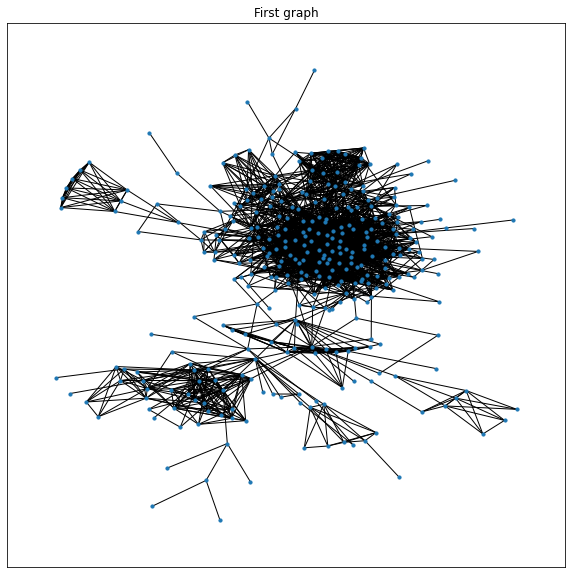

In [16]:
# Visualizaton of the first subgraph
Edge_graph = nx.from_edgelist(Facebook_graphs[0].edge_list)
visualize( Edge_graph, "First graph")

In [17]:
# The features of the fisrt graph's first node
Facebook_graphs[0].X[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.])

In [18]:
# The edges of the first graph
Facebook_graphs[0].edge_index

tensor([[235, 121,  23,  ...,  84,  97, 290],
        [185, 284, 345,  ...,  74, 331, 338]])

In [19]:
# The Node2Vec embeddings of the first graph
Facebook_graphs[0].embeddings

tensor([[ 0.6463,  0.5955, -0.5157,  ...,  0.2813, -1.5460, -0.9518],
        [-0.0479,  0.4634,  1.3321,  ...,  0.0528, -0.5982, -1.1496],
        [ 0.0509,  0.6721,  0.7832,  ...,  0.0209, -0.3979, -0.6311],
        ...,
        [ 0.0493,  0.0310, -0.3566,  ..., -0.5850,  0.3000, -1.7113],
        [ 0.2670,  0.2099, -1.0893,  ...,  0.2879,  0.2533,  1.1386],
        [-0.7360,  0.0937, -0.8065,  ..., -0.5293,  0.8592,  1.0612]])

In [20]:
#Names of the features in the first graph
Facebook_graphs[0].X_names

[['0 birthday'],
 ['1 birthday'],
 ['2 birthday'],
 ['3 birthday'],
 ['4 birthday'],
 ['5 birthday'],
 ['6 birthday'],
 ['7 birthday'],
 ['8 education', 'classes', 'id'],
 ['9 education', 'classes', 'id'],
 ['10 education', 'classes', 'id'],
 ['11 education', 'classes', 'id'],
 ['12 education', 'classes', 'id'],
 ['13 education', 'concentration', 'id'],
 ['14 education', 'concentration', 'id'],
 ['15 education', 'concentration', 'id'],
 ['16 education', 'concentration', 'id'],
 ['17 education', 'concentration', 'id'],
 ['18 education', 'concentration', 'id'],
 ['19 education', 'concentration', 'id'],
 ['20 education', 'degree', 'id'],
 ['21 education', 'degree', 'id'],
 ['22 education', 'degree', 'id'],
 ['23 education', 'degree', 'id'],
 ['24 education', 'school', 'id'],
 ['25 education', 'school', 'id'],
 ['26 education', 'school', 'id'],
 ['27 education', 'school', 'id'],
 ['28 education', 'school', 'id'],
 ['29 education', 'school', 'id'],
 ['30 education', 'school', 'id'],
 ['31 e

# Whole graph

In [21]:
f = open('facebook_combined.txt', "rt")
text = f.readlines()

all_edge_index = [(int(x.split()[0]), int(x.split()[1])) for x in text]  
all_edge_index = torch.tensor(all_edge_index).T
print(all_edge_index)

tensor([[   0,    0,    0,  ..., 4027, 4027, 4031],
        [   1,    2,    3,  ..., 4032, 4038, 4038]])


In [22]:
# Here we convert our graph, because Node2Vec expects an NX graph     
H = nx.from_edgelist(all_edge_index.T.numpy())
# When we transform the graph this way, we lose the isolated nodes ( the ones that only connect with the ego)
# so with an extra step we add extra nodes to represent the isolated nodes
max_ = all_edge_index[0, :].max()
for node_id in range(max_ -1):
    if node_id not in H:
        H.add_node(node_id)

# creating the Node2Vec embeddings 
n2v = Node2Vec(n_components=64, walklen=10, epochs=50, return_weight=1.0, neighbor_weight=1.0, threads=0, w2vparams={'window': 4, 'negative': 5, 'iter':10, 'ns_exponent': 0.5, 'batch_words': 128})

# Fit and get the embedding
n2v.fit(H)
#Getting the nodes of the graph
nodes = H.nodes()
embeddings = []
for node in nodes:
    embeddings.append(n2v.predict(node))

Making walks... Done, T=0.47
Mapping Walk Names... Done, T=3.07
Training W2V... Done, T=67.89


In [23]:
# Class to store all the information about the given graph - for the whole graph
class GraphData2:
  edge_index = []
  embeddings = []

  def __init__(self, edges, embeddings):
    self.edge_index = edges 
    self.embeddings = embeddings
    

# Link Prediction - GNN Autoencoder

### Training function

In [170]:
class GNNVAE(nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels):
    super(GNNVAE,self).__init__()
    # GCN layers
    #self.GNNConvIn = GCNConv(in_channels=in_channels, out_channels=hidden_channels)
    #self.GNNConvHidden = GCNConv(in_channels=hidden_channels, out_channels=hidden_channels)
    #self.GNNConvOut = GCNConv(in_channels=hidden_channels, out_channels=out_channels)
    
    #GIN Layers
    self.GNNConvIn = GINConv(MLP([in_channels, hidden_channels, hidden_channels]))
    self.GNNConvHidden = GINConv(MLP([hidden_channels, hidden_channels, hidden_channels]))
    self.GNNConvOut = GINConv(MLP([hidden_channels, hidden_channels, out_channels]))
    
  # The encoder part is a GCN network
  def encode(self,x,edge_index):
    x = self.GNNConvIn(x,edge_index).relu()
    x = self.GNNConvOut(x,edge_index).relu()
    return x

  # The decoder part of the network 
  def decode(self,z,edges):
    return (z[edges[0]] * z[edges[1]]).sum(dim=-1)

  # training function
  def train_GNNVAE(self, train_dataset,val_dataset,optimizer,epoch,verbose=False):
    for epoch in range(0,epoch):
      self.train()
      optimizer.zero_grad()
      # Transport data to GPU if nessesery
      x, edge_index, edge_label_index = train_dataset.x.to(device), train_dataset.edge_index.to(device), train_dataset.edge_label_index.to(device)
     
      # The autoencoder's hidden representation
      z = self.encode(x,edge_index)
      
      # Adding negativ edges to the graph
      # The number of negativ edges will be the same as the positiv edges (num_neg_samples=len(edge_label_index[1]))
      neg_edge_index = negative_sampling(
              edge_index=edge_index, num_nodes=torch.tensor(train_dataset.num_nodes).to(device),
              num_neg_samples=len(edge_label_index[1]), method='sparse')
      
      # Adding the negativ edges to the original (positiv) edges of the graph 
      pos_neg_edge_index = torch.cat(
          [edge_label_index, neg_edge_index],
          dim=-1,
      )
    
      # Creating the ground truth labels for the edges: 0 if it's a negativ and 1 if it's a positiv edge
      edge_y = torch.cat([
          torch.ones(neg_edge_index.size(1)).to(device),
          train_dataset.edge_label.new_zeros(neg_edge_index.size(1)).to(device)
      ], dim=0)
      
      # decoder part of the autoencoder
      out = self.decode(z,pos_neg_edge_index)

      # Definiing our loss function
      loss_fn = torch.nn.BCEWithLogitsLoss()
      loss = loss_fn(out,edge_y)
      loss.backward()
      optimizer.step()

      # validation step
      if (verbose and epoch % 10 == 0):
        val_roc_auc = self.eval_GNNVAE(val_dataset)
        print(f"Train loss: {loss}\nValidation AUC: {val_roc_auc}")
    return self


  # Custum eval function
  @torch.no_grad()
  def eval_GNNVAE(self, data):
    self.eval()
     # Transport data to GPU if nessesery
    x, edge_index, edge_label_index = data.x.to(device), data.edge_index.to(device), data.edge_label_index.to(device)
    # The validation and test data already contain negative edges via Graph Link Split
    # So in this step we do not need to manually add them
    z = self.encode(x, edge_index)
    out = self.decode(z, edge_label_index).view(-1).sigmoid()
    #ROC score and accuracy
    acc = (data.edge_label.cpu().numpy() == np.round(out.cpu().numpy())).sum() / len(data.edge_label.cpu().numpy())
    roc =  roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())
    
    # Classification report and cunfusion matrix
    y_true = data.edge_label.cpu().numpy()
    y_pred = np.round(out.cpu().numpy())
    print(classification_report(y_true, y_pred, labels=[0, 1]))
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negativ edge","Positiv edge"])
    disp.plot()
    plt.show()
    #ROC curve visualization
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
    display.plot()
    plt.show()
    
    #Test graph visualization
    Edge_graph = nx.from_edgelist(data.edge_label_index.T.numpy())
 
    color_map = {
    (0, 0): '#6495ed', # BLue - True Negative edges
    (0, 1): '#ffc107', #Yellow - False Pozitive edes
    (1, 0): '#dc3545', # Red - False Negative edges
    (1, 1): '#000000'  # Black - True Pozitive edges
    }

    # Create a new list using the map
    color_list = [color_map[(a, b)] for a, b in zip(y_pred, y_true)]
    visualize(Edge_graph, "Graph", color_list)
    
    return roc, acc


# Training

## I. Traing for the whole facebook graph - with the Node2Vec embeddings

train_data: Data(x=[4039, 64], edge_index=[2, 150000], edge_label=[75000], edge_label_index=[2, 75000])
val_data: Data(x=[4039, 64], edge_index=[2, 150000], edge_label=[8822], edge_label_index=[2, 8822])
test_data: Data(x=[4039, 64], edge_index=[2, 158822], edge_label=[17646], edge_label_index=[2, 17646])
0.9472401677433979
              precision    recall  f1-score   support

           0       0.98      0.91      0.95      8823
           1       0.92      0.99      0.95      8823

    accuracy                           0.95     17646
   macro avg       0.95      0.95      0.95     17646
weighted avg       0.95      0.95      0.95     17646



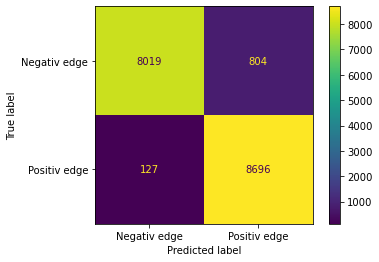

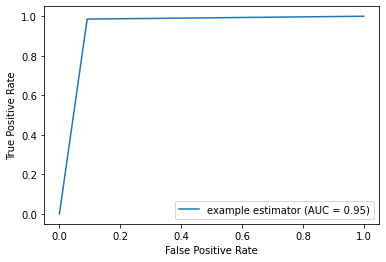

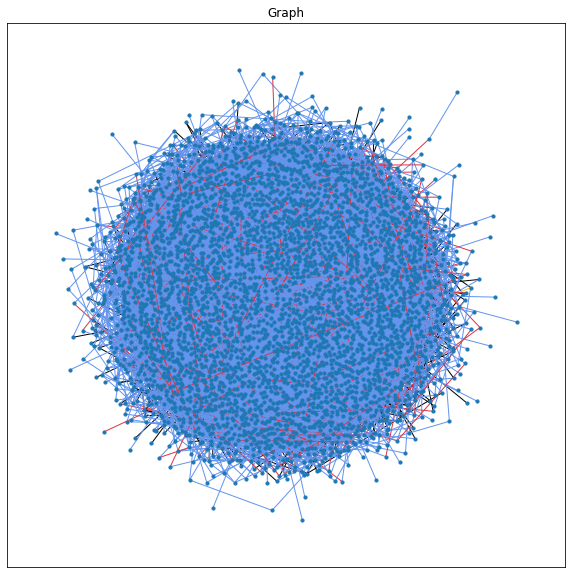

Test AUC: 0.981
Test Accuracy: 0.947


In [174]:
graph = GraphData2(all_edge_index, torch.tensor(embeddings) )
train_data, val_data, test_data = split_data(graph, 0)
model = GNNVAE(train_data.x.shape[1], 39, 21).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.00866)

model = model.train_GNNVAE(train_data, val_data, optimizer,450)
test_auc_whole_graph, test_acc_whole_graph = model.eval_GNNVAE(test_data)

print(f"Test AUC: {test_auc_whole_graph:.3f}")
print(f"Test Accuracy: {test_acc_whole_graph:.3f}")

## II. Traing for the subgraphs separatly - with the Node2Vec embeddings

train_data: Data(x=[347, 64], edge_index=[2, 4286], edge_label=[2143], edge_label_index=[2, 2143])
val_data: Data(x=[347, 64], edge_index=[2, 4286], edge_label=[250], edge_label_index=[2, 250])
test_data: Data(x=[347, 64], edge_index=[2, 4536], edge_label=[502], edge_label_index=[2, 502])
0.8665338645418327
              precision    recall  f1-score   support

           0       0.88      0.85      0.86       251
           1       0.86      0.88      0.87       251

    accuracy                           0.87       502
   macro avg       0.87      0.87      0.87       502
weighted avg       0.87      0.87      0.87       502



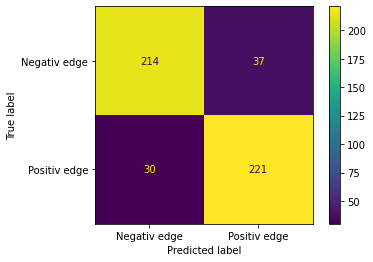

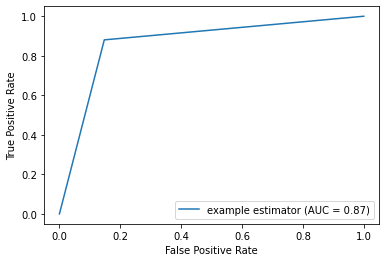

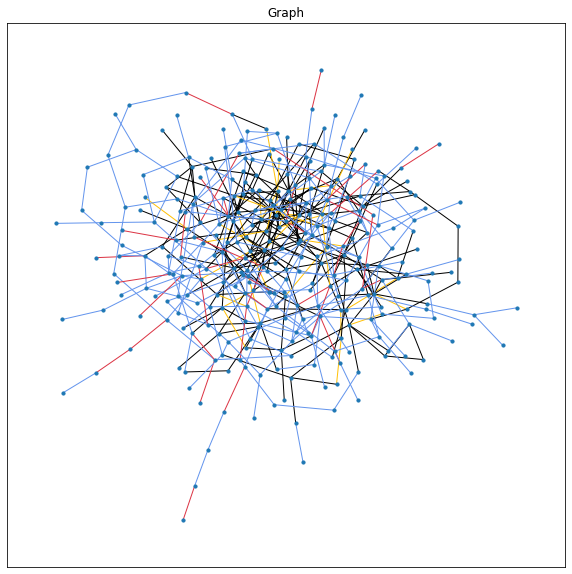

Test auc: 0.907, test accuracy: 0.867
train_data: Data(x=[1045, 64], edge_index=[2, 45476], edge_label=[22738], edge_label_index=[2, 22738])
val_data: Data(x=[1045, 64], edge_index=[2, 45476], edge_label=[2674], edge_label_index=[2, 2674])
test_data: Data(x=[1045, 64], edge_index=[2, 48150], edge_label=[5348], edge_label_index=[2, 5348])
0.8612565445026178
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      2674
           1       0.88      0.83      0.86      2674

    accuracy                           0.86      5348
   macro avg       0.86      0.86      0.86      5348
weighted avg       0.86      0.86      0.86      5348



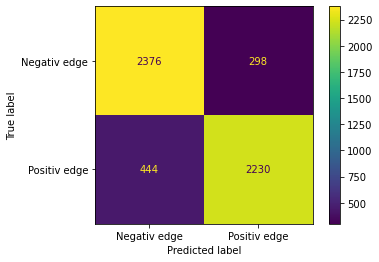

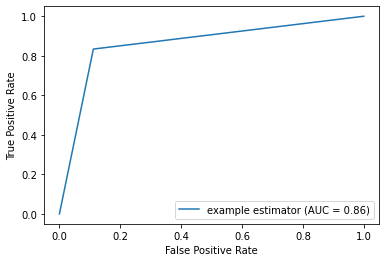

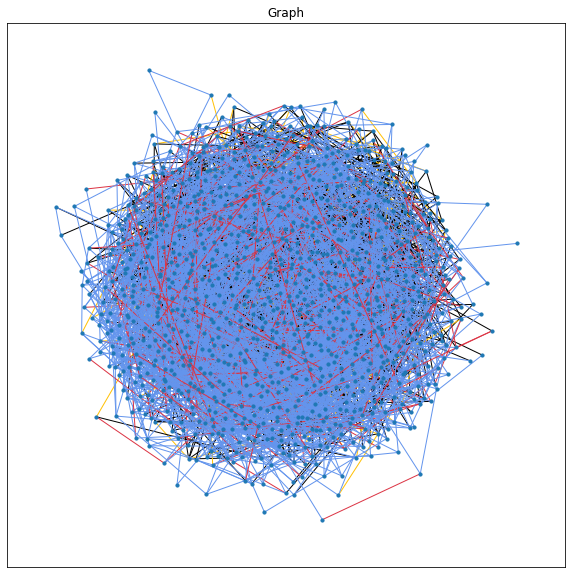

Test auc: 0.894, test accuracy: 0.861
train_data: Data(x=[227, 64], edge_index=[2, 5428], edge_label=[2714], edge_label_index=[2, 2714])
val_data: Data(x=[227, 64], edge_index=[2, 5428], edge_label=[318], edge_label_index=[2, 318])
test_data: Data(x=[227, 64], edge_index=[2, 5746], edge_label=[638], edge_label_index=[2, 638])
0.8056426332288401
              precision    recall  f1-score   support

           0       0.87      0.71      0.79       319
           1       0.76      0.90      0.82       319

    accuracy                           0.81       638
   macro avg       0.82      0.81      0.80       638
weighted avg       0.82      0.81      0.80       638



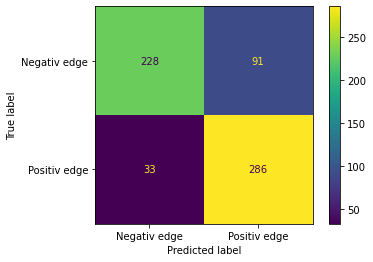

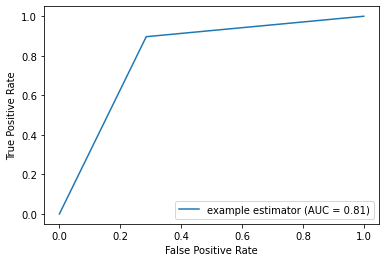

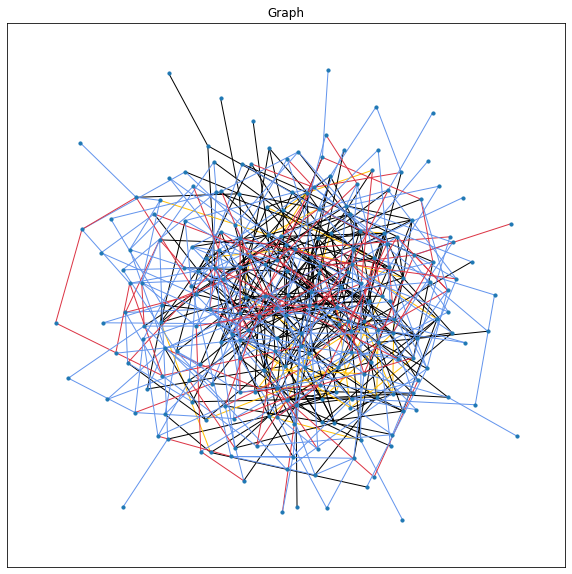

Test auc: 0.899, test accuracy: 0.806
train_data: Data(x=[159, 64], edge_index=[2, 2880], edge_label=[1440], edge_label_index=[2, 1440])
val_data: Data(x=[159, 64], edge_index=[2, 2880], edge_label=[168], edge_label_index=[2, 168])
test_data: Data(x=[159, 64], edge_index=[2, 3048], edge_label=[338], edge_label_index=[2, 338])
0.8136094674556213
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       169
           1       0.84      0.78      0.81       169

    accuracy                           0.81       338
   macro avg       0.82      0.81      0.81       338
weighted avg       0.82      0.81      0.81       338



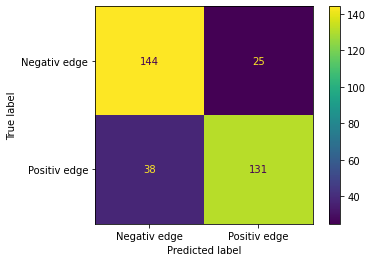

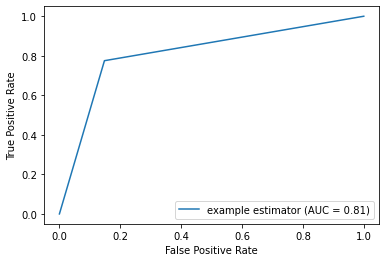

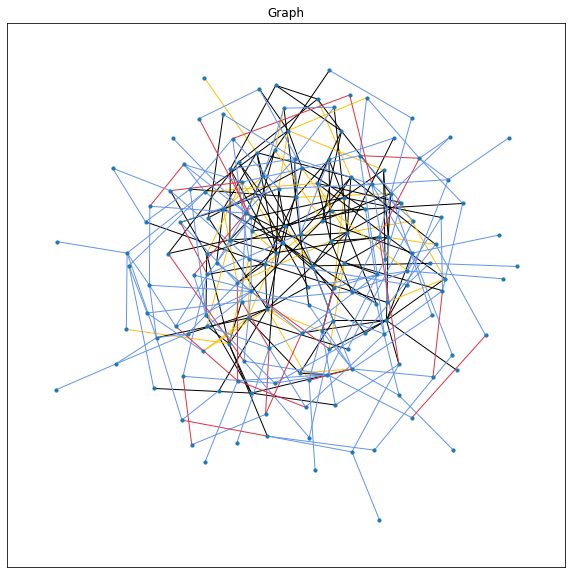

Test auc: 0.861, test accuracy: 0.814
train_data: Data(x=[170, 64], edge_index=[2, 2818], edge_label=[1409], edge_label_index=[2, 1409])
val_data: Data(x=[170, 64], edge_index=[2, 2818], edge_label=[164], edge_label_index=[2, 164])
test_data: Data(x=[170, 64], edge_index=[2, 2982], edge_label=[330], edge_label_index=[2, 330])
0.7757575757575758
              precision    recall  f1-score   support

           0       0.82      0.71      0.76       165
           1       0.74      0.84      0.79       165

    accuracy                           0.78       330
   macro avg       0.78      0.78      0.77       330
weighted avg       0.78      0.78      0.77       330



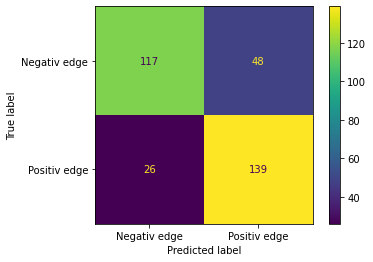

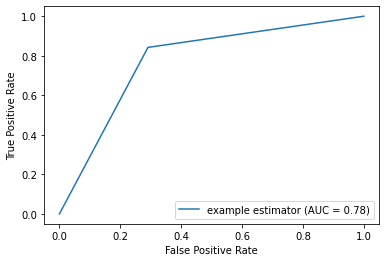

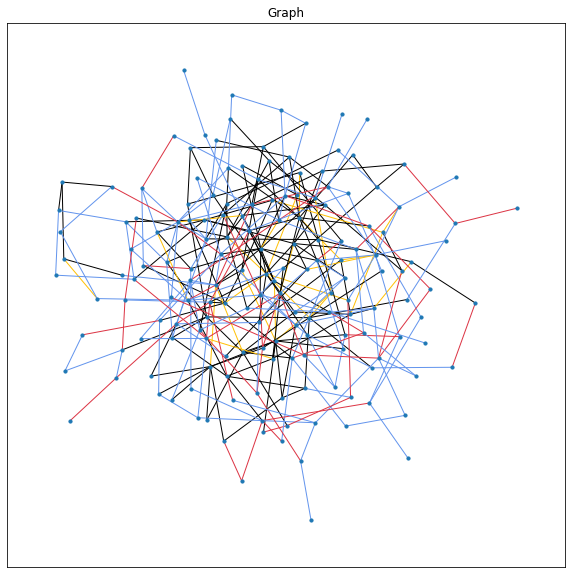

Test auc: 0.858, test accuracy: 0.776
train_data: Data(x=[66, 64], edge_index=[2, 460], edge_label=[230], edge_label_index=[2, 230])
val_data: Data(x=[66, 64], edge_index=[2, 460], edge_label=[26], edge_label_index=[2, 26])
test_data: Data(x=[66, 64], edge_index=[2, 486], edge_label=[54], edge_label_index=[2, 54])
0.9259259259259259
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        27
           1       0.93      0.93      0.93        27

    accuracy                           0.93        54
   macro avg       0.93      0.93      0.93        54
weighted avg       0.93      0.93      0.93        54



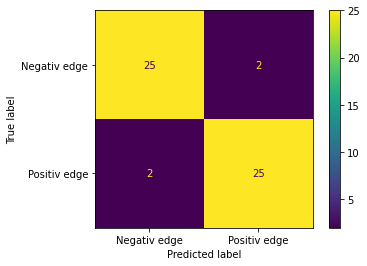

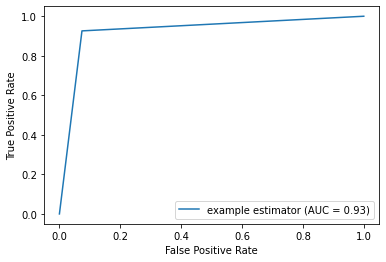

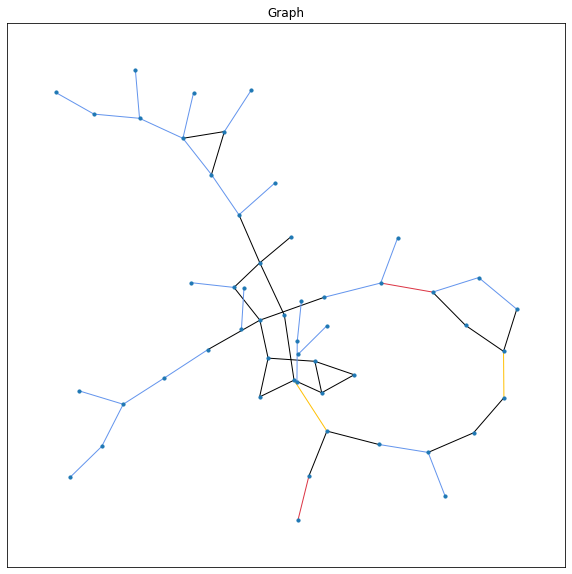

Test auc: 0.955, test accuracy: 0.926
train_data: Data(x=[792, 64], edge_index=[2, 23842], edge_label=[11921], edge_label_index=[2, 11921])
val_data: Data(x=[792, 64], edge_index=[2, 23842], edge_label=[1402], edge_label_index=[2, 1402])
test_data: Data(x=[792, 64], edge_index=[2, 25244], edge_label=[2804], edge_label_index=[2, 2804])
0.8527104136947218
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1402
           1       0.83      0.89      0.86      1402

    accuracy                           0.85      2804
   macro avg       0.85      0.85      0.85      2804
weighted avg       0.85      0.85      0.85      2804



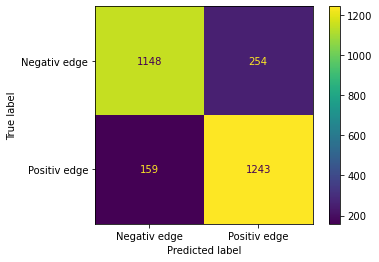

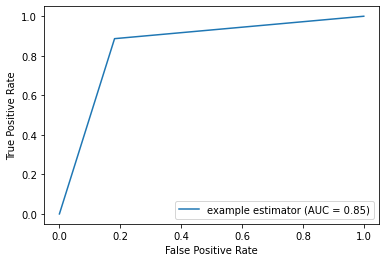

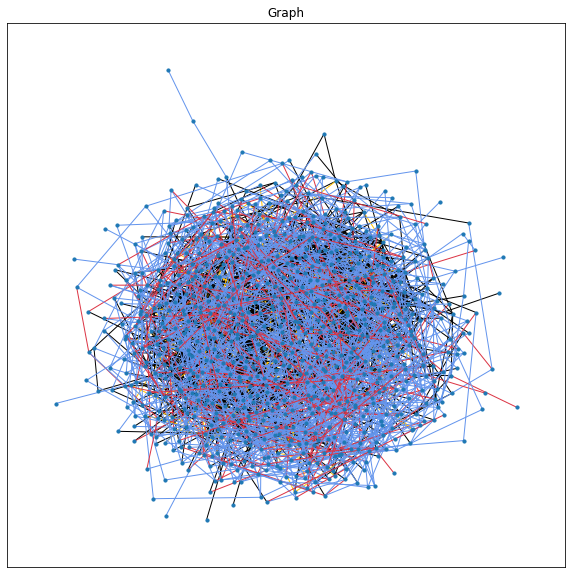

Test auc: 0.912, test accuracy: 0.853
train_data: Data(x=[755, 64], edge_index=[2, 51044], edge_label=[25522], edge_label_index=[2, 25522])
val_data: Data(x=[755, 64], edge_index=[2, 51044], edge_label=[3002], edge_label_index=[2, 3002])
test_data: Data(x=[755, 64], edge_index=[2, 54046], edge_label=[6004], edge_label_index=[2, 6004])
0.8837441705529647
              precision    recall  f1-score   support

           0       0.86      0.91      0.89      3002
           1       0.91      0.85      0.88      3002

    accuracy                           0.88      6004
   macro avg       0.89      0.88      0.88      6004
weighted avg       0.89      0.88      0.88      6004



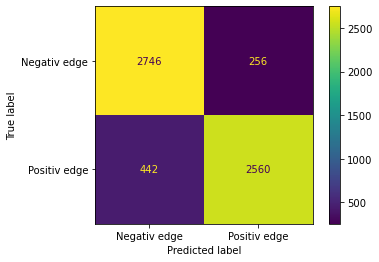

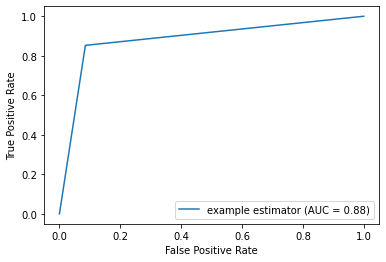

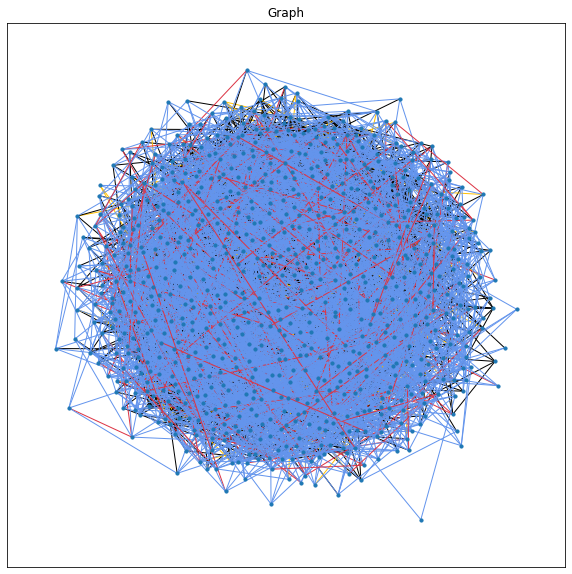

Test auc: 0.912, test accuracy: 0.884
train_data: Data(x=[547, 64], edge_index=[2, 8184], edge_label=[4092], edge_label_index=[2, 4092])
val_data: Data(x=[547, 64], edge_index=[2, 8184], edge_label=[480], edge_label_index=[2, 480])
test_data: Data(x=[547, 64], edge_index=[2, 8664], edge_label=[962], edge_label_index=[2, 962])
0.8336798336798337
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       481
           1       0.86      0.79      0.83       481

    accuracy                           0.83       962
   macro avg       0.84      0.83      0.83       962
weighted avg       0.84      0.83      0.83       962



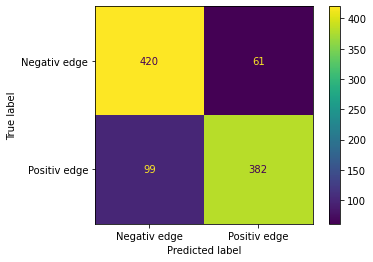

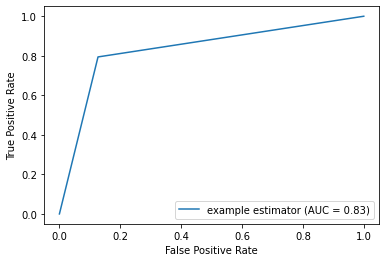

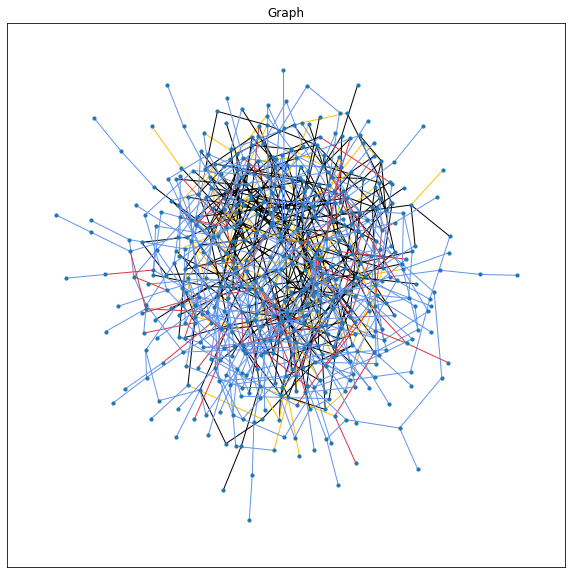

Test auc: 0.868, test accuracy: 0.834
train_data: Data(x=[59, 64], edge_index=[2, 250], edge_label=[125], edge_label_index=[2, 125])
val_data: Data(x=[59, 64], edge_index=[2, 250], edge_label=[14], edge_label_index=[2, 14])
test_data: Data(x=[59, 64], edge_index=[2, 264], edge_label=[28], edge_label_index=[2, 28])
0.9285714285714286
              precision    recall  f1-score   support

           0       1.00      0.86      0.92        14
           1       0.88      1.00      0.93        14

    accuracy                           0.93        28
   macro avg       0.94      0.93      0.93        28
weighted avg       0.94      0.93      0.93        28



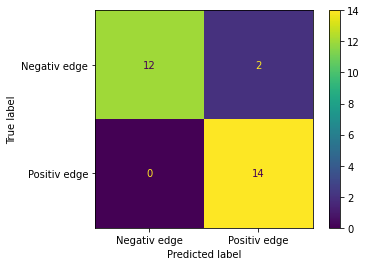

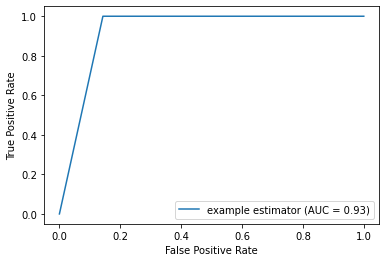

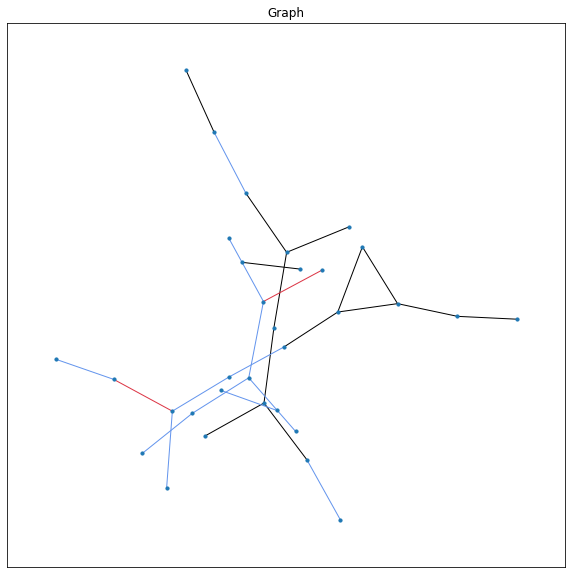

Test auc: 0.990, test accuracy: 0.929
Average Test AUC: 0.9054748417116059
Average Test accuracy: 0.8547431857911361


In [171]:
# We used the best hiperparameters from the Optuna optimalization
n2v_test_aucs = []
n2v_test_acc = []
for i in range(len(Facebook_graphs)):
  graph = Facebook_graphs[i]
  train_data, val_data, test_data = split_data(graph, 0)
  model = GNNVAE(train_data.x.shape[1], 46, 10).to(device)
  optimizer = torch.optim.Adam(params=model.parameters(), lr=0.00955926)

  model = model.train_GNNVAE(train_data, val_data, optimizer,300)
  test_auc, test_acc = model.eval_GNNVAE(test_data)
  n2v_test_aucs.append(test_auc)
  n2v_test_acc.append(test_acc)

  print(f"Test auc: {test_auc:.3f}, test accuracy: {test_acc:.3f}")
print(f"Average Test AUC: {np.array(n2v_test_aucs).sum() / len(n2v_test_aucs)}")
print(f"Average Test accuracy: {np.array(n2v_test_acc).sum() / len(n2v_test_acc)}")

train_data: Data(x=[59, 64], edge_index=[2, 250], edge_label=[125], edge_label_index=[2, 125])
val_data: Data(x=[59, 64], edge_index=[2, 250], edge_label=[14], edge_label_index=[2, 14])
test_data: Data(x=[59, 64], edge_index=[2, 264], edge_label=[28], edge_label_index=[2, 28])
0.9285714285714286
              precision    recall  f1-score   support

           0       0.88      1.00      0.93        14
           1       1.00      0.86      0.92        14

    accuracy                           0.93        28
   macro avg       0.94      0.93      0.93        28
weighted avg       0.94      0.93      0.93        28



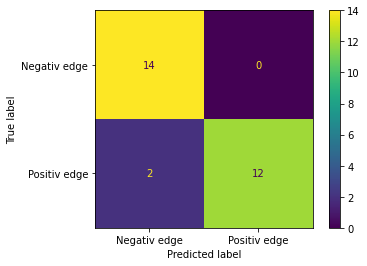

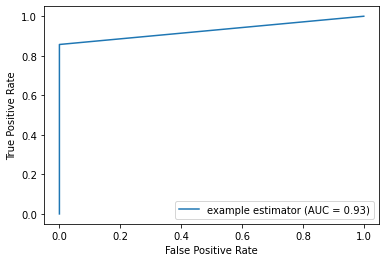

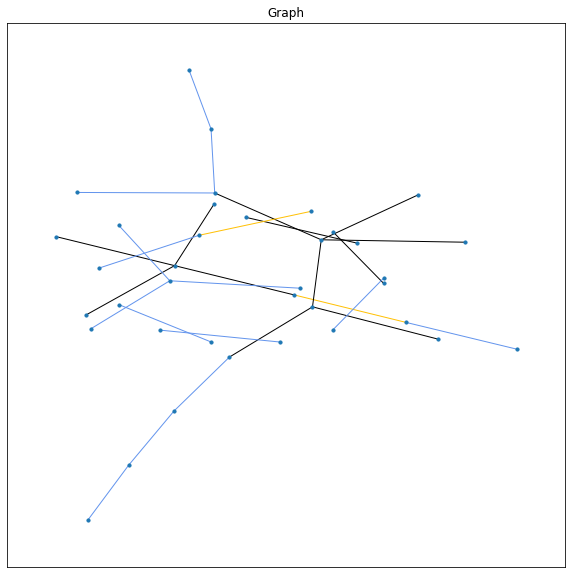

In [181]:
graph = Facebook_graphs[9]
train_data, val_data, test_data = split_data(graph, 0)
model = GNNVAE(train_data.x.shape[1], 46, 10).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.00955926)

model = model.train_GNNVAE(train_data, val_data, optimizer,300)
test_auc, test_acc = model.eval_GNNVAE(test_data)

## III. Traing for the subgraphs separatly - with the original node features

train_data: Data(x=[347, 223], edge_index=[2, 4286], edge_label=[2143], edge_label_index=[2, 2143])
val_data: Data(x=[347, 223], edge_index=[2, 4286], edge_label=[250], edge_label_index=[2, 250])
test_data: Data(x=[347, 223], edge_index=[2, 4536], edge_label=[502], edge_label_index=[2, 502])
0.8466135458167331
              precision    recall  f1-score   support

           0       0.86      0.83      0.84       251
           1       0.84      0.86      0.85       251

    accuracy                           0.85       502
   macro avg       0.85      0.85      0.85       502
weighted avg       0.85      0.85      0.85       502



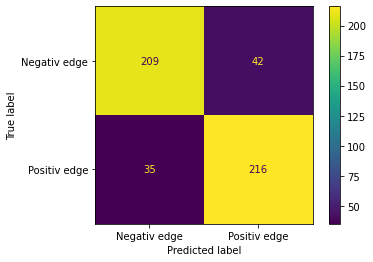

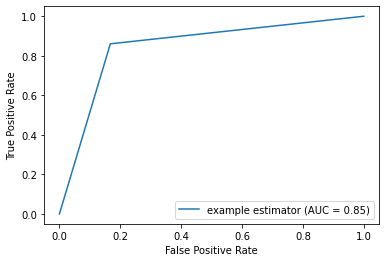

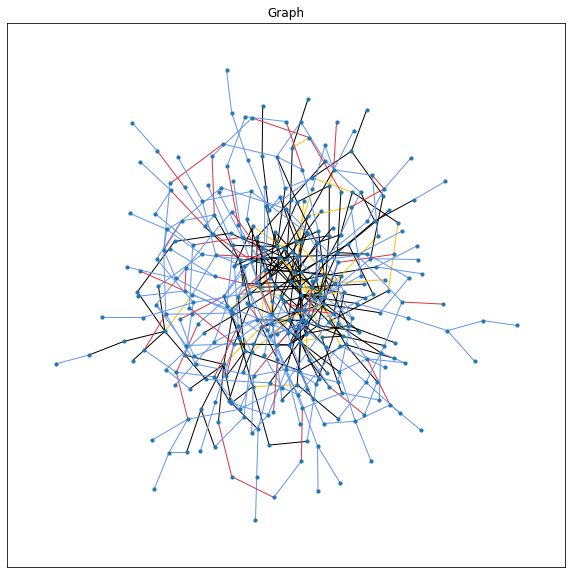

Test auc: 0.891, test accuracy: 0.847
train_data: Data(x=[1045, 575], edge_index=[2, 45476], edge_label=[22738], edge_label_index=[2, 22738])
val_data: Data(x=[1045, 575], edge_index=[2, 45476], edge_label=[2674], edge_label_index=[2, 2674])
test_data: Data(x=[1045, 575], edge_index=[2, 48150], edge_label=[5348], edge_label_index=[2, 5348])
0.8223635003739715
              precision    recall  f1-score   support

           0       0.78      0.90      0.84      2674
           1       0.88      0.74      0.81      2674

    accuracy                           0.82      5348
   macro avg       0.83      0.82      0.82      5348
weighted avg       0.83      0.82      0.82      5348



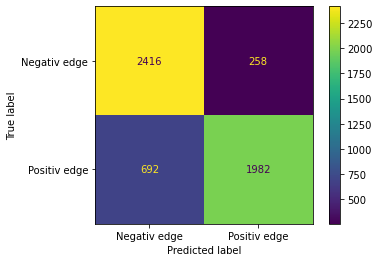

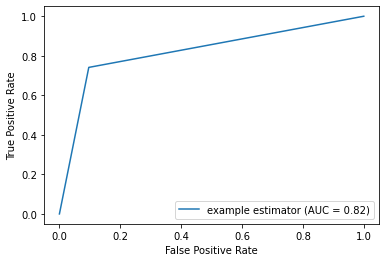

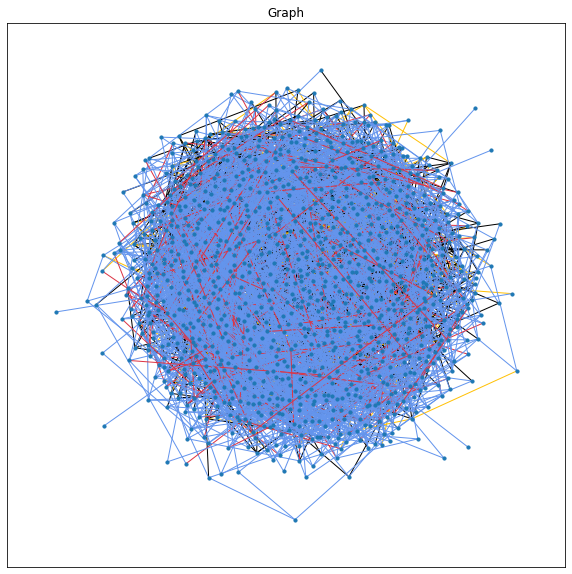

Test auc: 0.846, test accuracy: 0.822
train_data: Data(x=[227, 160], edge_index=[2, 5428], edge_label=[2714], edge_label_index=[2, 2714])
val_data: Data(x=[227, 160], edge_index=[2, 5428], edge_label=[318], edge_label_index=[2, 318])
test_data: Data(x=[227, 160], edge_index=[2, 5746], edge_label=[638], edge_label_index=[2, 638])
0.835423197492163
              precision    recall  f1-score   support

           0       0.88      0.78      0.83       319
           1       0.80      0.89      0.84       319

    accuracy                           0.84       638
   macro avg       0.84      0.84      0.83       638
weighted avg       0.84      0.84      0.83       638



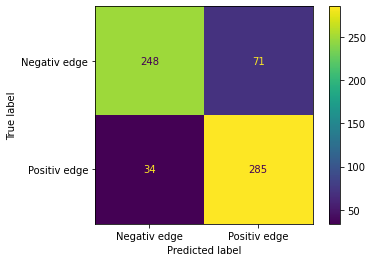

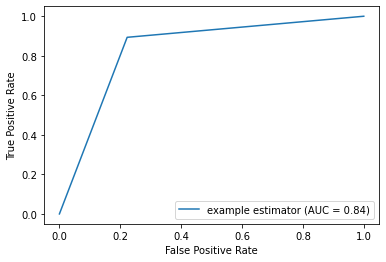

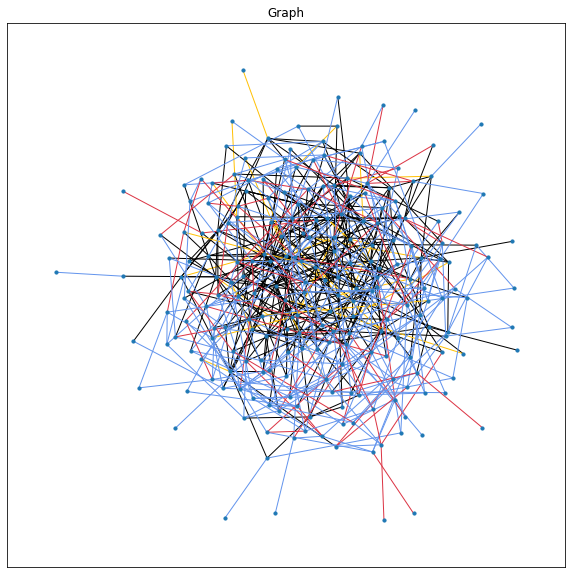

Test auc: 0.897, test accuracy: 0.835
train_data: Data(x=[159, 104], edge_index=[2, 2880], edge_label=[1440], edge_label_index=[2, 1440])
val_data: Data(x=[159, 104], edge_index=[2, 2880], edge_label=[168], edge_label_index=[2, 168])
test_data: Data(x=[159, 104], edge_index=[2, 3048], edge_label=[338], edge_label_index=[2, 338])
0.9023668639053254
              precision    recall  f1-score   support

           0       0.93      0.88      0.90       169
           1       0.88      0.93      0.90       169

    accuracy                           0.90       338
   macro avg       0.90      0.90      0.90       338
weighted avg       0.90      0.90      0.90       338



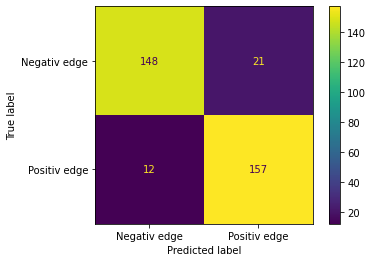

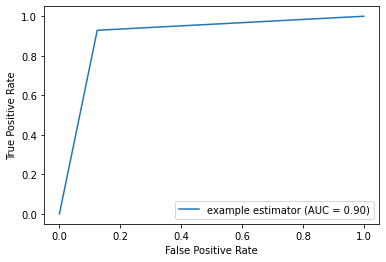

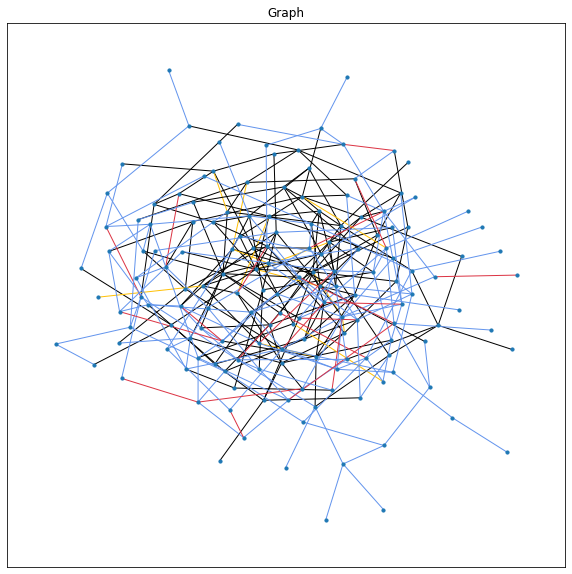

Test auc: 0.932, test accuracy: 0.902
train_data: Data(x=[170, 62], edge_index=[2, 2818], edge_label=[1409], edge_label_index=[2, 1409])
val_data: Data(x=[170, 62], edge_index=[2, 2818], edge_label=[164], edge_label_index=[2, 164])
test_data: Data(x=[170, 62], edge_index=[2, 2982], edge_label=[330], edge_label_index=[2, 330])
0.7606060606060606
              precision    recall  f1-score   support

           0       0.77      0.75      0.76       165
           1       0.76      0.77      0.76       165

    accuracy                           0.76       330
   macro avg       0.76      0.76      0.76       330
weighted avg       0.76      0.76      0.76       330



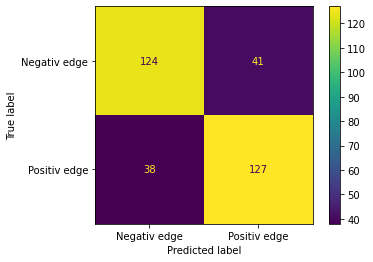

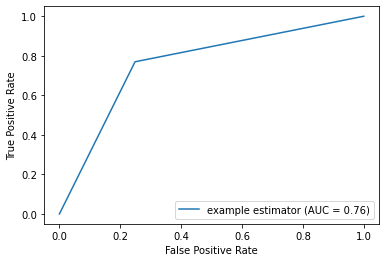

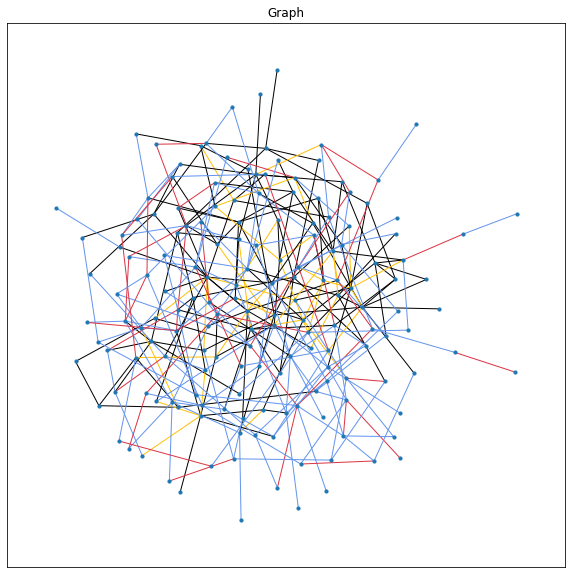

Test auc: 0.826, test accuracy: 0.761
train_data: Data(x=[66, 47], edge_index=[2, 460], edge_label=[230], edge_label_index=[2, 230])
val_data: Data(x=[66, 47], edge_index=[2, 460], edge_label=[26], edge_label_index=[2, 26])
test_data: Data(x=[66, 47], edge_index=[2, 486], edge_label=[54], edge_label_index=[2, 54])
0.8888888888888888
              precision    recall  f1-score   support

           0       0.84      0.96      0.90        27
           1       0.96      0.81      0.88        27

    accuracy                           0.89        54
   macro avg       0.90      0.89      0.89        54
weighted avg       0.90      0.89      0.89        54



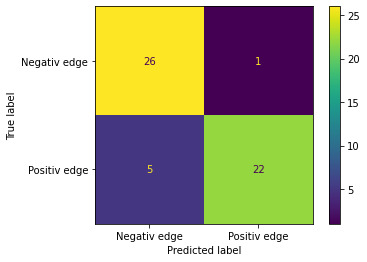

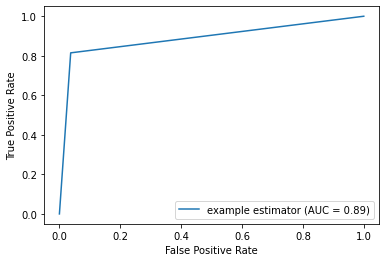

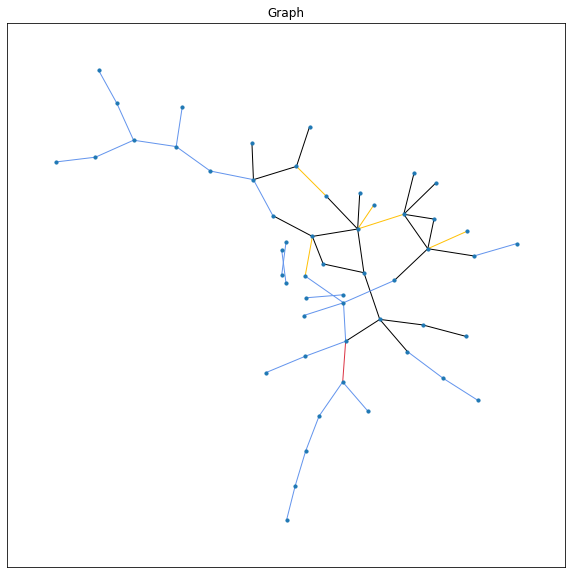

Test auc: 0.892, test accuracy: 0.889
train_data: Data(x=[792, 318], edge_index=[2, 23842], edge_label=[11921], edge_label_index=[2, 11921])
val_data: Data(x=[792, 318], edge_index=[2, 23842], edge_label=[1402], edge_label_index=[2, 1402])
test_data: Data(x=[792, 318], edge_index=[2, 25244], edge_label=[2804], edge_label_index=[2, 2804])
0.8484308131241084
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      1402
           1       0.82      0.89      0.85      1402

    accuracy                           0.85      2804
   macro avg       0.85      0.85      0.85      2804
weighted avg       0.85      0.85      0.85      2804



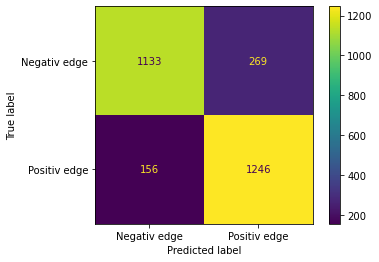

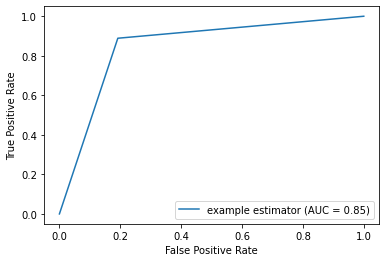

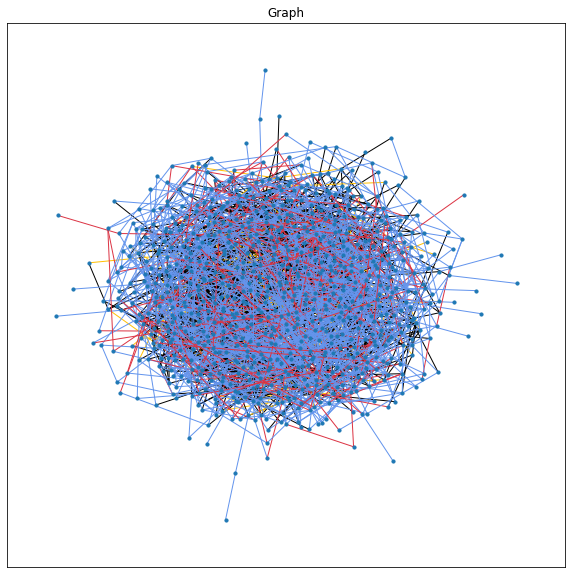

Test auc: 0.902, test accuracy: 0.848
train_data: Data(x=[755, 479], edge_index=[2, 51044], edge_label=[25522], edge_label_index=[2, 25522])
val_data: Data(x=[755, 479], edge_index=[2, 51044], edge_label=[3002], edge_label_index=[2, 3002])
test_data: Data(x=[755, 479], edge_index=[2, 54046], edge_label=[6004], edge_label_index=[2, 6004])
0.8787475016655563
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      3002
           1       0.89      0.86      0.88      3002

    accuracy                           0.88      6004
   macro avg       0.88      0.88      0.88      6004
weighted avg       0.88      0.88      0.88      6004



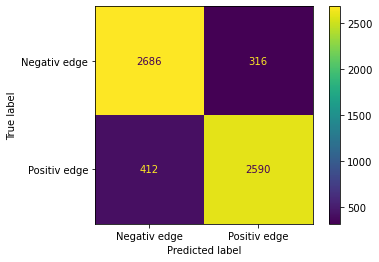

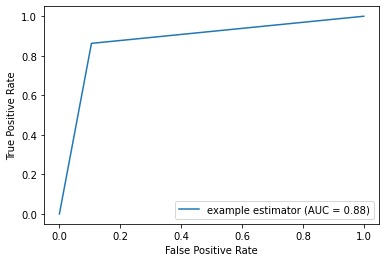

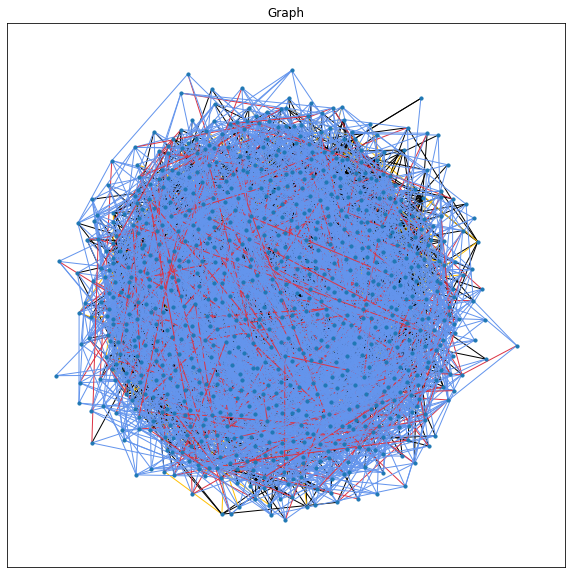

Test auc: 0.912, test accuracy: 0.879
train_data: Data(x=[547, 261], edge_index=[2, 8184], edge_label=[4092], edge_label_index=[2, 4092])
val_data: Data(x=[547, 261], edge_index=[2, 8184], edge_label=[480], edge_label_index=[2, 480])
test_data: Data(x=[547, 261], edge_index=[2, 8664], edge_label=[962], edge_label_index=[2, 962])
0.8804573804573804
              precision    recall  f1-score   support

           0       0.88      0.89      0.88       481
           1       0.88      0.88      0.88       481

    accuracy                           0.88       962
   macro avg       0.88      0.88      0.88       962
weighted avg       0.88      0.88      0.88       962



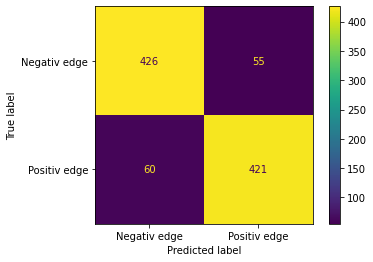

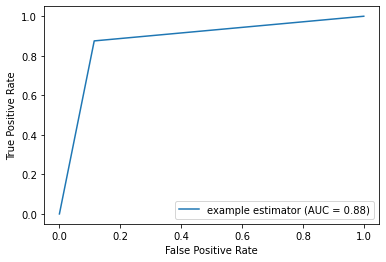

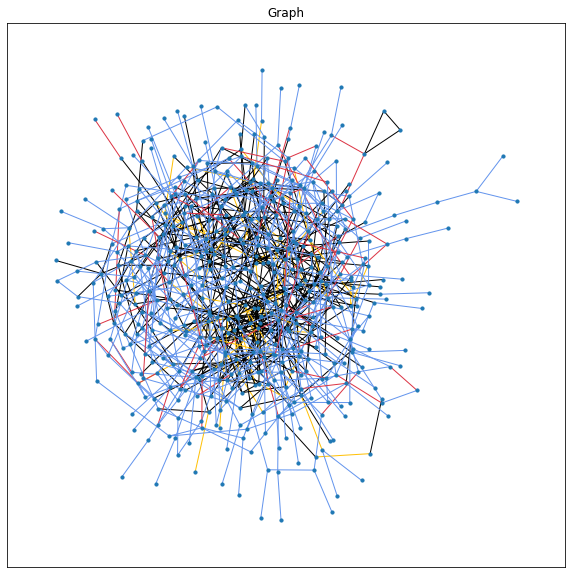

Test auc: 0.915, test accuracy: 0.880
train_data: Data(x=[59, 41], edge_index=[2, 250], edge_label=[125], edge_label_index=[2, 125])
val_data: Data(x=[59, 41], edge_index=[2, 250], edge_label=[14], edge_label_index=[2, 14])
test_data: Data(x=[59, 41], edge_index=[2, 264], edge_label=[28], edge_label_index=[2, 28])
0.7857142857142857
              precision    recall  f1-score   support

           0       0.75      0.86      0.80        14
           1       0.83      0.71      0.77        14

    accuracy                           0.79        28
   macro avg       0.79      0.79      0.78        28
weighted avg       0.79      0.79      0.78        28



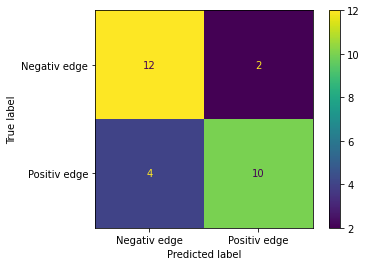

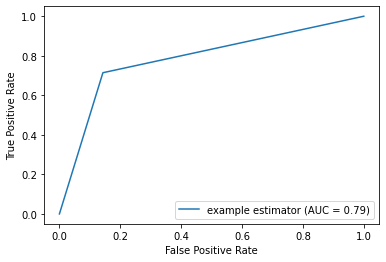

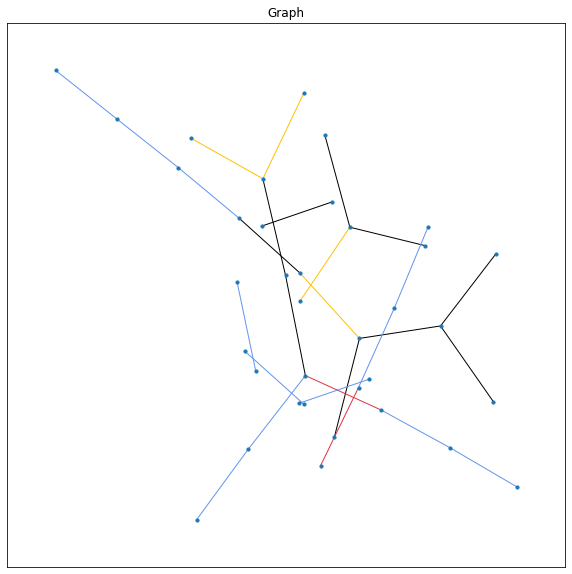

Test auc: 0.806, test accuracy: 0.786
Average Test AUC: 0.8818231967451068
Average Test accuracy: 0.8449612038044473


In [175]:
f_test_aucs = []
f_test_acc = []
for i in range(len(Facebook_graphs)):
  graph = Facebook_graphs[i]
  train_data, val_data, test_data = split_data(graph, 1)
  model = GNNVAE(train_data.x.shape[1], 32, 18).to(device)
  optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0228967)

  model = model.train_GNNVAE(train_data, val_data, optimizer,300)
  test_auc, test_acc = model.eval_GNNVAE(test_data)
  f_test_aucs.append(test_auc)
  f_test_acc.append(test_acc)

  print(f"Test auc: {test_auc:.3f}, test accuracy: {test_acc:.3f}")
print(f"Average Test AUC: {np.array(f_test_aucs).sum() / len(f_test_aucs)}")
print(f"Average Test accuracy: {np.array(f_test_acc).sum() / len(f_test_acc)}")

## IV. Traing for the subgraphs separatly - with the original node features and the node embeddings

In [34]:
f_test_aucs = []
f_test_acc = []
for i in range(len(Facebook_graphs)):
  graph = Facebook_graphs[i]
  train_data, val_data, test_data = split_data(graph, 2)
  model = GNNVAE(train_data.x.shape[1], 32, 8).to(device)
  optimizer = torch.optim.Adam(params=model.parameters(), lr=0.007317)

  model = model.train_GNNVAE(train_data, val_data, optimizer,300)
  test_auc, test_acc = model.eval_GNNVAE(test_data)
  f_test_aucs.append(test_auc)
  f_test_acc.append(test_acc)

  print(f"Test auc: {test_auc:.3f}, test accuracy: {test_acc:.3f}")
print(f"Average Test AUC: {np.array(f_test_aucs).sum() / len(f_test_aucs)}")
print(f"Average Test accuracy: {np.array(f_test_acc).sum() / len(f_test_acc)}")

train_data: Data(x=[347, 287], edge_index=[2, 4286], edge_label=[2143], edge_label_index=[2, 2143])
val_data: Data(x=[347, 287], edge_index=[2, 4286], edge_label=[250], edge_label_index=[2, 250])
test_data: Data(x=[347, 287], edge_index=[2, 4536], edge_label=[502], edge_label_index=[2, 502])
0.8446215139442231
Test auc: 0.899, test accuracy: 0.845
train_data: Data(x=[1045, 639], edge_index=[2, 45476], edge_label=[22738], edge_label_index=[2, 22738])
val_data: Data(x=[1045, 639], edge_index=[2, 45476], edge_label=[2674], edge_label_index=[2, 2674])
test_data: Data(x=[1045, 639], edge_index=[2, 48150], edge_label=[5348], edge_label_index=[2, 5348])
0.881077038145101
Test auc: 0.926, test accuracy: 0.881
train_data: Data(x=[227, 224], edge_index=[2, 5428], edge_label=[2714], edge_label_index=[2, 2714])
val_data: Data(x=[227, 224], edge_index=[2, 5428], edge_label=[318], edge_label_index=[2, 318])
test_data: Data(x=[227, 224], edge_index=[2, 5746], edge_label=[638], edge_label_index=[2, 63

# Statisztika a 3 modell teljesítményéről a 3 különböző gráfon

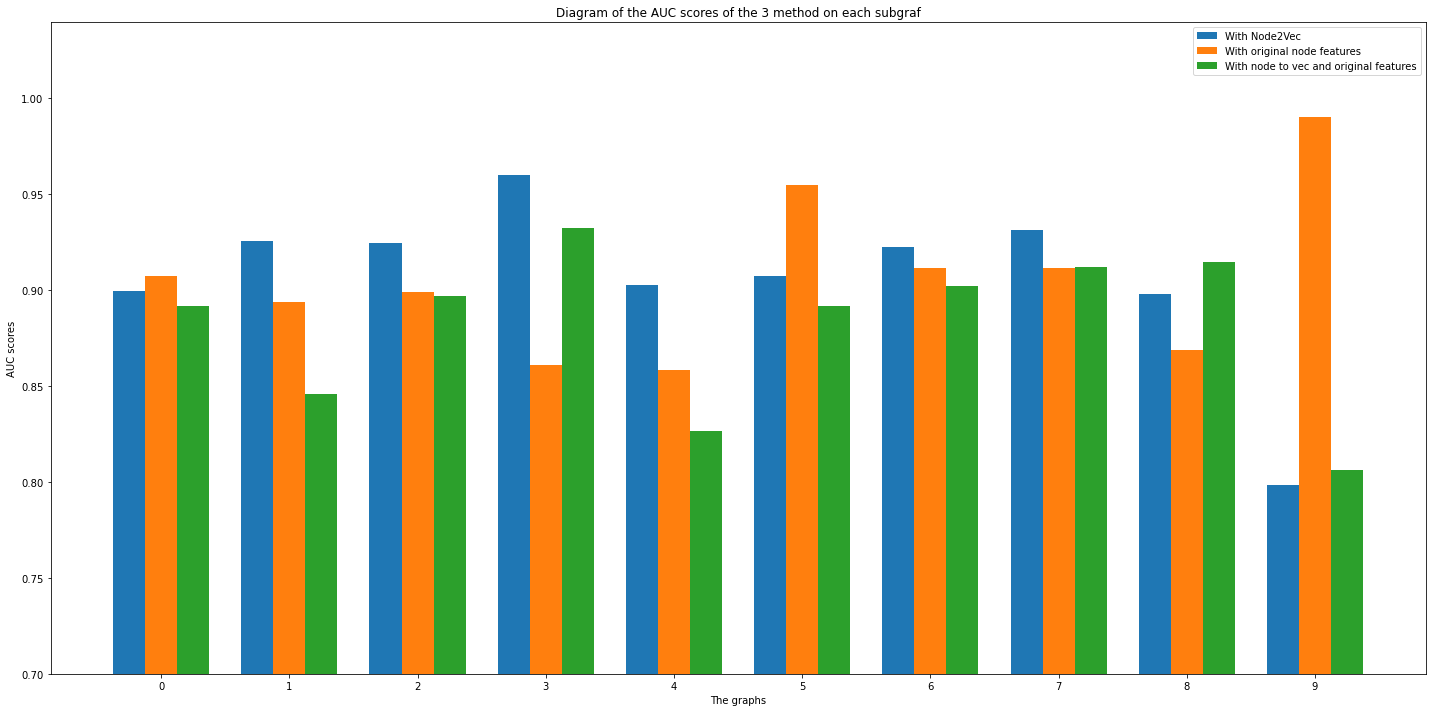

In [178]:
# Oszlopok pozíciói
bar_width = 0.25
index = np.arange(10)
plt.figure(figsize=(20,10))
# Oszlopdiagramok rajzolása
plt.bar(index, f_n2v_test_aucs, bar_width, label='With Node2Vec')
plt.bar(index + bar_width, n2v_test_aucs, bar_width, label='With original node features')
plt.bar(index + 2*bar_width, f_test_aucs, bar_width, label='With node to vec and original features')

# Címek és címkék

plt.xlabel('The graphs')
plt.ylabel('AUC scores')
plt.title('Diagram of the AUC scores of the 3 method on each subgraf')
plt.xticks(index + bar_width, range(10))
plt.legend()
plt.ylim(0.7)

# Diagram megjelenítése
plt.tight_layout()
plt.show()

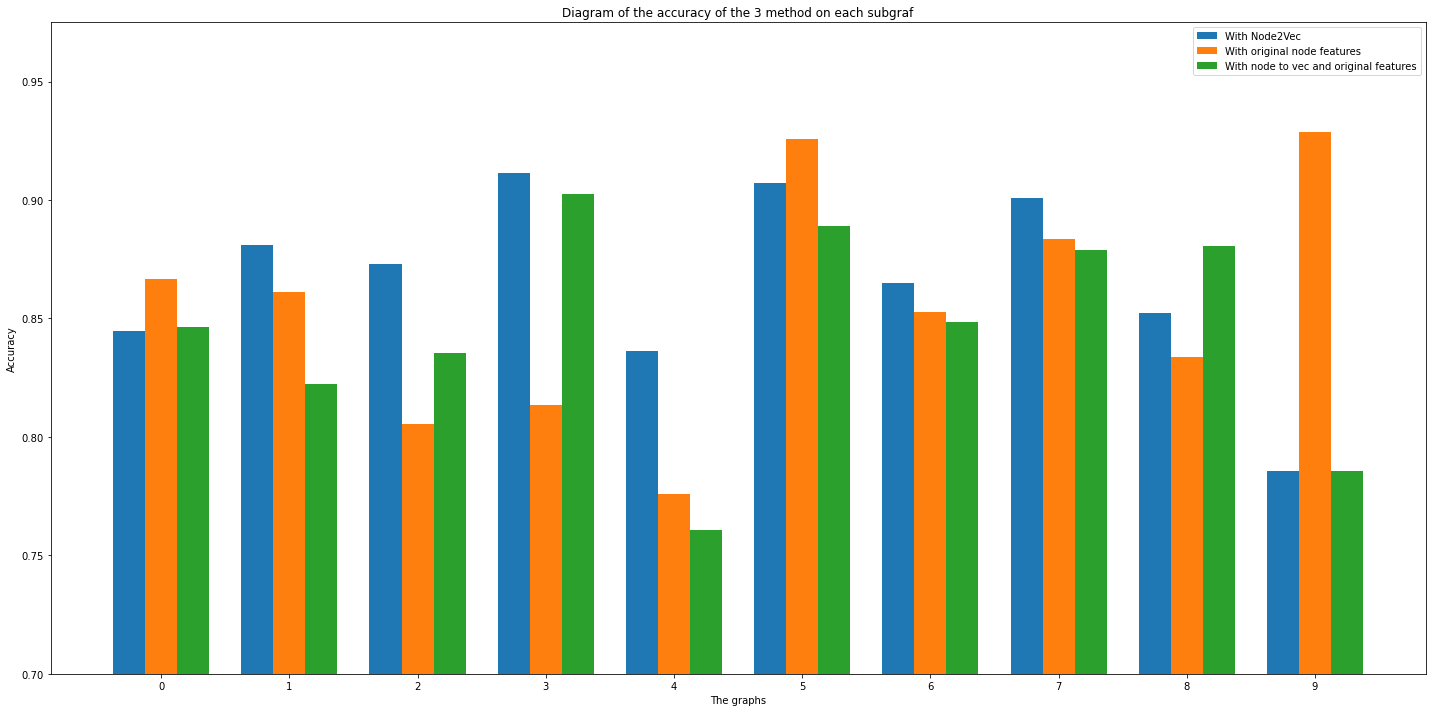

In [179]:
# Oszlopok pozíciói
bar_width = 0.25
index = np.arange(10)
plt.figure(figsize=(20,10))
# Oszlopdiagramok rajzolása
plt.bar(index, f_n2v_test_acc, bar_width, label='With Node2Vec')
plt.bar(index + bar_width, n2v_test_acc, bar_width, label='With original node features')
plt.bar(index + 2*bar_width, f_test_acc, bar_width, label='With node to vec and original features')

# Címek és címkék

plt.xlabel('The graphs')
plt.ylabel('Accuracy')
plt.title('Diagram of the accuracy of the 3 method on each subgraf')
plt.xticks(index + bar_width, range(10))
plt.legend()
plt.ylim(0.7)

# Diagram megjelenítése
plt.tight_layout()
plt.show()

In [64]:
! pip freeze

alabaster @ file:///home/ktietz/src/ci/alabaster_1611921544520/work
anaconda-anon-usage @ file:///C:/b/abs_95v3x0wy8p/croot/anaconda-anon-usage_1697038984188/work
anaconda-client @ file:///C:/ci/anaconda-client_1635342725944/work
anaconda-cloud-auth @ file:///C:/b/abs_410afndtyf/croot/anaconda-cloud-auth_1697462767853/work
anaconda-navigator @ file:///C:/b/abs_ab00e0_u7e/croot/anaconda-navigator_1695238210954/work
anaconda-project @ file:///tmp/build/80754af9/anaconda-project_1626085644852/work
anyio @ file:///C:/ci/anyio_1620153135622/work/dist
appdirs==1.4.4
argh==0.26.2
argon2-cffi @ file:///C:/ci/argon2-cffi_1613037869401/work
arrow @ file:///C:/ci/arrow_1617738834352/work
asn1crypto @ file:///tmp/build/80754af9/asn1crypto_1596577642040/work
astroid @ file:///C:/ci/astroid_1628063282661/work
astropy @ file:///C:/ci/astropy_1629829318700/work
async-generator @ file:///home/ktietz/src/ci/async_generator_1611927993394/work
atomicwrites==1.4.0
attrs @ file:///tmp/build/80754af9/attrs_1